Given a model of observations $y$ that depends on latent variables $x$ (drawn from a short list of primitive distributions) and unknown parameters $\theta$, we want to estimate the max likelihood (or better yet, distribution over) $\theta$ that produced observations $y$.

Generically, $y = f(x, \theta)$.

But specifically, we'll start with

$y = \theta * x$, where $x \sim Normal(0, 1)$.

How would we solve this by hand? Well, in this case, I know $\theta$ comes in linearly, so I can just measure the variance of $y$ (or maybe better, measure the average deviation from 0) and pick $\theta$ to scale it to 1.

Working it out in terms of evidence (using notation $f[a](b)$ for a density $f$ over variable $a$ evaluated at point $b$):

$$p(y | x) = Delta[ \theta * x](y)\\
p(x) = N[0, 1](x) \\
\theta^* = \arg\max_\theta \sum_i \log p(y_i) = \arg\max_\theta \sum_i \log \int dx\ p(x, y_i) \\
= \arg\max_\theta \sum_i \log \int dx\ p(y_i | x) p(x) \\
= \arg\max_\theta \sum_i \log \int dx\ Delta[\theta * x](y_i) N[0, 1](x) \\
$$

The Delta is only nonzero at $x = \dfrac{y_i}{\theta}$, so this simplifies:

$$
= \arg\max_\theta \sum_i \Big( \log N[0, 1](\dfrac{y_i}{\theta}) \Big) \\
\sim \arg\max_\theta \sum_i \Big( -\dfrac{y_i^2}{\theta^2} \Big)  \\
$$

which is maximized as $\theta \to \infty$.

If instead the model is $p(y|x) = Delta[x](y)$ and $p(x) = N[0, \theta^2](x)$, then it instead looks like:
$$
= \arg\max_\theta \sum_i \Big( \log N[0, \theta^2](y_i) \Big) \\
\sim \arg\max_\theta \sum_i \Big( \log \dfrac{1}{\sqrt{2 \pi \theta^2}}-\dfrac{y_i^2}{2 \theta^2} \Big)  \\
$$
which is maximized when (I relied on Wolfram for this derivative since I don't want to pull out paper...)
$$
0 = \sum_i \Big( \dfrac{-1}{\theta} + \dfrac{y_i^2}{\theta^3} \Big) \\
N * \theta^2 = \sum_i y_i^2 \\
\theta = \sqrt{\dfrac{1}{N} \sum_i y_i^2}
$$
which is the familiar standard deviation estimation formula.


In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def f(theta, x):
    return theta * x

np.random.seed(42)
N = 100
theta_gt = 2.7
x_gt = np.random.randn(N)
data = f(theta_gt, x_gt)
print("X draws: ", x_gt)
print("Y draws: ", data)

# Best possible GT estimate
theta_best_est = np.sqrt(np.mean(np.square(data)))
print("Closed-form estimate of theta: ", theta_best_est)

('X draws: ', array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004,
       -0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
       -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ,
        1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272,
        0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375,
       -0.60170661,  1.85227818, -0.01349722, -1.05771093,  0.82254491,
       -1.22084365,  0.2088636 , -1.95967012, -1.32818605,  0.19686124,
        0.73846658,  0.17136828, -0.11564828, -0.3011037 , -1.47852199,
       -0.71984421, -0.46063877,  1.05712223,  0.34361829, -1.76304016,
        0.32408397, -0.38508228, -0.676922  ,  0.61167629,  1.03099952,
        0.93128012, -0.83921752, -0.30921238,  0.33126343,  0.97554513,
       -0.47917424, -0.18565898, -1.10633497, -1.19620662,  0.81252582,
        1.35624003, -0.07201012,  1.0035329 ,  0.3

Estimated theta (using closed form): 2.455822
Estimated theta = 2.503727 (var 0.173186)
Estimated x: [ 0.54236954 -0.14263551  0.6998399   1.6449234  -0.24855903 -0.24910808
  1.6974769   0.829185   -0.5085621   0.5855198  -0.49598634 -0.49936846
  0.26027432 -2.0638046  -1.862582   -0.606288   -1.0890754   0.34133175
 -0.9850791  -1.5286282   1.5826308  -0.24068847  0.07723758 -1.5369935
 -0.59240264  0.12020172 -1.2415818   0.4033928  -0.6461149  -0.31429082
 -0.6544417   1.9969671  -0.00951067 -1.1465716   0.8851095  -1.3114979
  0.23024233 -2.1122024  -1.4311813   0.21991488  0.7997098   0.18136978
 -0.12166857 -0.31557223 -1.5954045  -0.7717728  -0.49316028  1.1413977
  0.3680902  -1.9002522   0.3430599  -0.41347012 -0.7276782   0.6572877
  1.1131473   1.0033928  -0.9038848  -0.33312178  0.35915726  1.0492911
 -0.5164424  -0.19551916 -1.1913925  -1.2885388   0.8759228   1.4634103
 -0.07602292  1.0787698   0.3946927  -0.6986005   0.3906488   1.6645474
 -0.03656223  1.6898336  -2.82

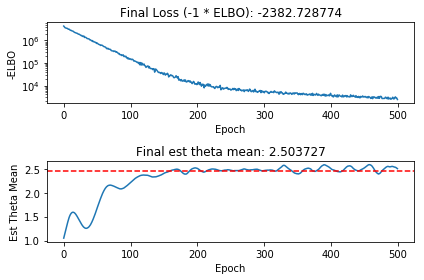

In [127]:
## PYRO VERSION USING SVI

import pyro
from pyro.contrib.autoguide import AutoDiagonalNormal
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import torch
import torch.distributions.constraints as constraints

unit_normal = dist.Normal(torch.tensor(0.), torch.tensor(1.))
def make_delta_distrib(mean, var=torch.tensor(0.0)):
    # Helper for optionally "softening" a Delta distribution
    # Var = 0 --> Delta distrib
    # Otherwise uses a Normal instead
    if var == 0.:
        return dist.Delta(mean)
    else:
        return dist.Normal(mean, var)
    
def model(data):
    # Extremely uninformative prior on the known parameter theta.
    theta = pyro.sample("theta",
                        dist.Normal(torch.tensor(5.),
                                    torch.tensor(10.0)))
    # Within this context, sampling + observation are batched over
    # the data, with each data point being independent.
    with pyro.plate("data", len(data)):
        # Sample x from uniform normal distribution
        x = pyro.sample("x", dist.Normal(torch.tensor(0.), torch.abs(theta)))
        # Run the model
        y = x # f(theta, x_i)
        # Observe the outcome.
        pyro.sample("y", make_delta_distrib(y, 0.01), obs=data)

# For our variational distribution, use a mean-field
# approximation with the variational factors being
# normal distributions.
def guide(data):
    # Need positivity to resolve +/- ambiguity, since underlying
    # normal distribution for x is symmetric
    theta_mean = pyro.param("est_theta_mean", torch.tensor(1.0),
                            constraint=constraints.positive)
    theta_var = pyro.param("est_theta_var", torch.tensor(0.1),
                           constraint=constraints.positive)
    theta = pyro.sample("theta", dist.Normal(theta_mean, theta_var))

    x = pyro.param("est_x_mean", torch.randn(len(data)))
    x_var = pyro.param("est_x_var", torch.tensor(1.).expand(len(data)),
                       constraint=constraints.positive)
    with pyro.plate("data"):
        # Sample x from uniform normal distribution
        pyro.sample("x", dist.Normal(x , x_var))

# Optimize with Adam, a first-order method
adam_params = {"lr": 0.05, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)

pyro.clear_param_store()
data_torch = torch.tensor(data, dtype=torch.float)
model(data_torch)
guide(data_torch)

svi = SVI(model, guide, optimizer, loss=Trace_ELBO(num_particles=5))

# do gradient steps
elbo = []
history_of_est_theta_mean = []
for step in range(500):
    elbo.append(svi.step(data_torch))
    history_of_est_theta_mean.append(pyro.param("est_theta_mean").item())

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(elbo)
plt.xlabel("Epoch")
plt.ylabel("-ELBO")
plt.yscale("log")
plt.title("Final Loss (-1 * ELBO): %f" % (-elbo[-1]))
plt.subplot(2, 1, 2)
plt.plot(history_of_est_theta_mean)
plt.gca().axhline(y=theta_best_est, linestyle="--", color="red")
plt.xlabel("Epoch")
plt.ylabel("Est Theta Mean")
plt.title("Final est theta mean: %f" % (history_of_est_theta_mean[-1]))
plt
plt.tight_layout()

# grab the learned variational parameters
est_theta_mean = pyro.param("est_theta_mean").item()
est_theta_var = pyro.param("est_theta_var").item()
est_x_mean = pyro.param("est_x_mean").cpu().detach().numpy()
est_x_var = pyro.param("est_x_var").cpu().detach().numpy()

print("Estimated theta (using closed form): %f" % (theta_best_est))
print("Estimated theta = %f (var %f)" % (est_theta_mean, est_theta_var))
print("Estimated x: %s" % (str(est_x_mean/est_theta_mean)))
print("Errors in estimated x: %s" % (str(est_x_mean/est_theta_mean - x_gt)))